#### Libraries

In [47]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import optuna
from sklearn.pipeline import make_pipeline
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

from warnings import filterwarnings
filterwarnings('ignore')

### About the project.

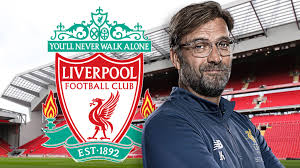

This notebook is just me trying to productionize this project of mine which was centred around a model that predicts the output of any EPL game involving Liverpool FC under Jurgen Klopp. 

*Caveat* This is just for learning. Although the data is real and was gotten from https://www.premierleague.com/tables , please do not gamble your hard-earned possessions with the outcome of this project.

The aim of this notebook is to design a model that predicts the 'Outcome', Win  or No_win, of an English Premier League game for Liverpool FC under Klopp's management based on such characteristics as:
1. 'Form' - This is Liverpool's current form. It takes into consideration their performance in the last 5 games. Top means they won at least 4 of the last 5 games, Decent means that they won 3 games, Poor means they won less than 3 games.

2. 'Opposition' - This is the measure of how much of a challenge the opposition team is. It takes into consideration their position on the English Premier League table at the time of the match. Tough means that the opposition club is top 6 on the table, or any of the 'Big Six' is placed top 9. Medium means that the opposition club is placed somewhere between positions 7 and 12 on the table, except for the 'Big Six' placed 7th, 8th, or 9th in which case they are still considered as Tough. Poor means that the opposition club is placed outside of the top 12 teams on the table. 

3. 'Season' - This is the time of the season the match will be played. There is Early, for matches that fall within first 11 matches. Matches that fall between 12th match of the season and 30th match of the season are considered as Middle, while the last 8 matches are considered Late.

4. 'Venue' - This is the ground the match will be played on. There is Home, when Liverpool FC are playing at home in front of their home fans, and Away when they are not.  

5. 'Previous_Match' - This is a record of the outcome of the previous Premier League match played by Liverpool FC. 1 if they won it, 0 otherwise (if they drew it, or lost it). 

6. 'UEFA' - This represents if Liverpool FC are engaged in European club football competitions at the time or not. Active for yes they are engaged in either UEFA Champions League or UEFA Europa League, Inactive for no they are not.

'Big Six' referenced above refers to the 6 clubs that have been dominating the league for over a decade, and have proven to be miles ahead of the other clubs in terms of how difficult it is to get the win over them. These clubs are: Manchester City, Chelsea, Manchester United, Arsenal, Tottenham Hotspurs, and Liverpool. So anytime Liverpool plays against any of the remaining 5 teams of the 'Big Six', as long as they are placed top 9 teams in the table, they are always considered Tough.

### Set Options.

In [48]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',90)
pd.options.display.float_format = '{:.6f}'.format

### Connect to mlflow

In [49]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Klopps-Liverpool-experiment")

<Experiment: artifact_location='file:///C:/Users/Odiaka/My_Shit/chapter/artifacts/1', creation_time=1687337491220, experiment_id='1', last_update_time=1687337491220, lifecycle_stage='active', name='Klopps-Liverpool-experiment', tags={}>

### Read Data.

In [50]:
data = pd.read_csv('data/liverpool.csv')

In [51]:
data.head()

,Date,Form,Opposition,Season,Venue,Previous_Match,UEFA,Outcome
0,17/10/2015,Poor,Tough,Early,Away,0,Active,No_win
1,25/10/2015,Poor,Medium,Early,Home,0,Active,No_win
2,31/10/2015,Poor,Medium,Early,Away,0,Active,Win
3,8/11/2015,Poor,Medium,Middle,Home,1,Active,No_win
4,21/11/2015,Poor,Tough,Middle,Away,0,Active,Win


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            257 non-null    object
 1   Form            257 non-null    object
 2   Opposition      257 non-null    object
 3   Season          257 non-null    object
 4   Venue           257 non-null    object
 5   Previous_Match  257 non-null    int64 
 6   UEFA            257 non-null    object
 7   Outcome         257 non-null    object
dtypes: int64(1), object(7)
memory usage: 16.2+ KB


#### Copy data.

In [53]:
data1 = data.copy()
data1.head()


,Date,Form,Opposition,Season,Venue,Previous_Match,UEFA,Outcome
0,17/10/2015,Poor,Tough,Early,Away,0,Active,No_win
1,25/10/2015,Poor,Medium,Early,Home,0,Active,No_win
2,31/10/2015,Poor,Medium,Early,Away,0,Active,Win
3,8/11/2015,Poor,Medium,Middle,Home,1,Active,No_win
4,21/11/2015,Poor,Tough,Middle,Away,0,Active,Win


### Exploring the data.

#### Data Preparation:

In [54]:
data1= data1.applymap(lambda s:s.lower().replace(' ', '_') if type(s) == str else s)
data1.columns = [x.lower().replace(' ', '_') for x in data1.columns]
data1.columns = [x.lower().replace(':', '') for x in data1.columns]
data1.columns = [x.lower().replace('*', '') for x in data1.columns]
data1.columns = [x.lower().replace('.', '') for x in data1.columns]

In [55]:
data1.head()

,date,form,opposition,season,venue,previous_match,uefa,outcome
0,17/10/2015,poor,tough,early,away,0,active,no_win
1,25/10/2015,poor,medium,early,home,0,active,no_win
2,31/10/2015,poor,medium,early,away,0,active,win
3,8/11/2015,poor,medium,middle,home,1,active,no_win
4,21/11/2015,poor,tough,middle,away,0,active,win


In [56]:
data1.shape

(257, 8)

In [57]:
data1['date'] = pd.to_datetime(data1['date'])

In [58]:
data1['date']

0     2015-10-17
1     2015-10-25
2     2015-10-31
3     2015-11-08
4     2015-11-21
         ...    
252   2022-04-30
253   2022-05-07
254   2022-05-10
255   2022-05-17
256   2022-05-22
Name: date, Length: 257, dtype: datetime64[ns]

In [59]:
data1['day'] = data1['date'].dt.day
data1['month'] = data1['date'].dt.month
data1['year'] = data1['date'].dt.year

In [60]:
data1 = data1.drop('date', axis=1)

#### Copy data.

In [61]:
data2 = data1.copy()
data2.head()

,form,opposition,season,venue,previous_match,uefa,outcome,day,month,year
0,poor,tough,early,away,0,active,no_win,17,10,2015
1,poor,medium,early,home,0,active,no_win,25,10,2015
2,poor,medium,early,away,0,active,win,31,10,2015
3,poor,medium,middle,home,1,active,no_win,8,11,2015
4,poor,tough,middle,away,0,active,win,21,11,2015


Missing values:

In [62]:
missing_value = pd.DataFrame({
    'Missing Value': data2.isnull().sum(),
    'Percentage': (data2.isnull().sum() / len(data2))*100
})

In [63]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
form,0,0.000000
opposition,0,0.000000
season,0,0.000000
venue,0,0.000000
previous_match,0,0.000000
uefa,0,0.000000
outcome,0,0.000000
day,0,0.000000
month,0,0.000000
year,0,0.000000


There are no missing values.

In [64]:
data2.isnull().sum()

form              0
opposition        0
season            0
venue             0
previous_match    0
uefa              0
outcome           0
day               0
month             0
year              0
dtype: int64

Duplicate Data:

In [65]:
duplicate = data2.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 0 duplicated rows in the data


data1.drop_duplicates(inplace=True)
data1.reset_index(inplace=True, drop=True)

### Feature Engineering.

In [66]:
data2

,form,opposition,season,venue,previous_match,uefa,outcome,day,month,year
0,poor,tough,early,away,0,active,no_win,17,10,2015
1,poor,medium,early,home,0,active,no_win,25,10,2015
2,poor,medium,early,away,0,active,win,31,10,2015
3,poor,medium,middle,home,1,active,no_win,8,11,2015
4,poor,tough,middle,away,0,active,win,21,11,2015
...,...,...,...,...,...,...,...,...,...,...
252,top,medium,late,away,1,active,win,30,4,2022
253,top,tough,late,home,1,active,no_win,7,5,2022
254,top,easy,late,away,0,active,win,10,5,2022
255,top,easy,late,away,1,active,win,17,5,2022


In [67]:
data2['result'] = data2['outcome'].replace(['win'], 1)
data2['result'] = data2['result'].replace(['no_win'], 0)

In [68]:
data2['ground'] = data2['venue'].replace(['home'], 1)
data2['ground'] = data2['ground'].replace(['away'], 0)

data2['foreign_league'] = data2['uefa'].replace(['active'], 1)
data2['foreign_league'] = data2['foreign_league'].replace(['inactive'], 0)

data2['time'] = data2['season'].replace(['early'], 0)
data2['time'] = data2['time'].replace(['middle'], 1)
data2['time'] = data2['time'].replace(['late'], 2)

data2['difficulty'] = data2['opposition'].replace(['tough'], 2)
data2['difficulty'] = data2['difficulty'].replace(['medium'], 1)
data2['difficulty'] = data2['difficulty'].replace(['easy'], 0)

data2['current_form'] = data2['form'].replace(['top'], 2)
data2['current_form'] = data2['current_form'].replace(['decent'], 1)
data2['current_form'] = data2['current_form'].replace(['poor'], 0)

In [69]:
categorical = data2.select_dtypes(include= ["object"]).columns
numerical = data2.select_dtypes(include=np.number).columns

In [70]:
data2.head()

,form,opposition,season,venue,previous_match,uefa,outcome,day,month,year,result,ground,foreign_league,time,difficulty,current_form
0,poor,tough,early,away,0,active,no_win,17,10,2015,0,0,1,0,2,0
1,poor,medium,early,home,0,active,no_win,25,10,2015,0,1,1,0,1,0
2,poor,medium,early,away,0,active,win,31,10,2015,1,0,1,0,1,0
3,poor,medium,middle,home,1,active,no_win,8,11,2015,0,1,1,1,1,0
4,poor,tough,middle,away,0,active,win,21,11,2015,1,0,1,1,2,0


#### Copy data.

In [71]:
data3 = data2.copy()
data3.head()

,form,opposition,season,venue,previous_match,uefa,outcome,day,month,year,result,ground,foreign_league,time,difficulty,current_form
0,poor,tough,early,away,0,active,no_win,17,10,2015,0,0,1,0,2,0
1,poor,medium,early,home,0,active,no_win,25,10,2015,0,1,1,0,1,0
2,poor,medium,early,away,0,active,win,31,10,2015,1,0,1,0,1,0
3,poor,medium,middle,home,1,active,no_win,8,11,2015,0,1,1,1,1,0
4,poor,tough,middle,away,0,active,win,21,11,2015,1,0,1,1,2,0


In [72]:
y = data3['result']
data3 = data3.drop(['result','outcome','year','venue','uefa','season','opposition','form'],axis=1)

In [73]:
data3

,previous_match,day,month,ground,foreign_league,time,difficulty,current_form
0,0,17,10,0,1,0,2,0
1,0,25,10,1,1,0,1,0
2,0,31,10,0,1,0,1,0
3,1,8,11,1,1,1,1,0
4,0,21,11,0,1,1,2,0
...,...,...,...,...,...,...,...,...
252,1,30,4,0,1,2,1,2
253,1,7,5,1,1,2,2,2
254,0,10,5,0,1,2,0,2
255,1,17,5,0,1,2,0,2


In [74]:
sm = SMOTE(random_state=42)
data3, y = sm.fit_resample(data3, y)

In [75]:
pd.Series(y).value_counts()

result
0    164
1    164
Name: count, dtype: int64

In [76]:
categorical = data3.select_dtypes(include= ["object"]).columns
numerical = data3.select_dtypes(include=np.number).columns

#### Splitting our data.

In [77]:
train_data, test_data, y_train_data, y_test = train_test_split(data3, y, test_size = 0.2, random_state=30)
print(train_data.shape,' ', test_data.shape)

(262, 8)   (66, 8)


In [78]:
train, val, y_train, y_val = train_test_split(train_data, y_train_data, test_size = 0.25, random_state=11)
print(train.shape,' ', val.shape)

train = train.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
val = val.reset_index(drop=True)

(196, 8)   (66, 8)


In [79]:
# separate majority and minority classes
n_majority = y_train.value_counts()[1]
n_minority = y_train.value_counts()[0]
N_majority = y_train_data.value_counts()[1]
N_minority = y_train_data.value_counts()[0]


# apply SMOTE to minority class
sm = SMOTE(sampling_strategy={1:n_majority},random_state=10)
train1, y_train1 = sm.fit_resample(train, y_train)
SM = SMOTE(sampling_strategy={1:N_majority},random_state=10)
train_data1, y_train_data1 = SM.fit_resample(train_data, y_train_data)

# downsample the majority class
train2 = train1[y_train1==0][:n_minority]
y_train2 = y_train1[y_train1==0][:n_minority]
train_data2 = train_data1[y_train_data1==0][:N_minority]
y_train_data2 = y_train_data1[y_train_data1==0][:N_minority]

# combine the downsampled majority class with the oversampled minority class
train = pd.DataFrame(np.concatenate((train2, train1[y_train1==1]), axis=0), columns=train.columns)
y_train = pd.DataFrame(np.concatenate((y_train2, y_train1[y_train1==1]), axis=0))
train_data = pd.DataFrame(np.concatenate((train_data2, train_data1[y_train_data1==1]), axis=0), columns=train_data.columns)
y_train_data = pd.DataFrame(np.concatenate((y_train_data2, y_train_data1[y_train_data1==1]), axis=0))

In [80]:
train_data

,previous_match,day,month,ground,foreign_league,time,difficulty,current_form
0,0,25,10,1,1,0,1,0
1,1,10,4,0,1,2,2,2
2,1,28,11,0,1,0,0,1
3,0,30,12,0,1,1,0,1
4,0,18,2,0,0,1,2,0
...,...,...,...,...,...,...,...,...
257,1,8,7,0,0,2,0,1
258,0,9,2,1,1,1,1,0
259,1,17,8,0,1,0,0,2
260,1,24,4,1,1,2,0,2


### Pre-modeling.

In [81]:
train_data.head()

,previous_match,day,month,ground,foreign_league,time,difficulty,current_form
0,0,25,10,1,1,0,1,0
1,1,10,4,0,1,2,2,2
2,1,28,11,0,1,0,0,1
3,0,30,12,0,1,1,0,1
4,0,18,2,0,0,1,2,0


In [82]:
from sklearn.feature_extraction import DictVectorizer
dict_train = train.to_dict(orient='records')
dict_val = val.to_dict(orient='records')
Dict_Train = train_data.to_dict(orient='records')
Dict_Test = test_data.to_dict(orient='records')
dv = DictVectorizer(sparse=False)

x_train = dv.fit_transform(dict_train)
x_val = dv.transform(dict_val)
X_Train = dv.fit_transform(Dict_Train)
X_Test = dv.transform(Dict_Test)

In [83]:
train

,previous_match,day,month,ground,foreign_league,time,difficulty,current_form
0,1,9,9,0,1,0,1,1
1,1,6,12,0,1,1,0,1
2,0,27,12,0,1,1,0,1
3,0,4,3,1,1,1,2,0
4,0,25,10,1,1,0,1,0
...,...,...,...,...,...,...,...,...
191,1,26,12,1,1,1,0,2
192,1,8,7,0,0,2,0,1
193,1,26,4,1,1,2,0,2
194,1,5,4,0,1,2,0,2


### Modeling.

##### Decision Tree

In [84]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)


y_pred_train = dt.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


y_pred = dt.predict(x_val)
print('Test Model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))



print(y_pred[0:10])
accuracy_score(y_val,y_pred)*100
precision = round(precision_score(y_val, y_pred),2)
recall = round(recall_score(y_val, y_pred),2)
print('Precision: ',precision)
print('Recall: ',recall)

Training-set accuracy score: 0.9949
Test Model accuracy score: 0.6515
[0 0 0 0 0 1 0 1 0 0]
Precision:  0.69
Recall:  0.55


##### Naive-Bayes

In [85]:
gnb = GaussianNB()


gnb.fit(x_train, y_train)


y_pred_train = gnb.predict(train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


y_pred = gnb.predict(x_val)
print('Test Model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))


print(y_pred[0:10])


print('Accuracy: ',round(accuracy_score(y_val,y_pred)*100,2),'%')
precision = round(precision_score(y_val, y_pred),2)
recall = round(recall_score(y_val, y_pred),2)
print('Precision: ',precision)
print('Recall: ',recall)

Training-set accuracy score: 0.5306
Test Model accuracy score: 0.6364
[0 0 0 0 0 0 0 1 1 1]
Accuracy:  63.64 %
Precision:  0.67
Recall:  0.55


##### XGBOOST

In [86]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 0.9),
    }
    
    # Create the pipeline with DictVectorizer and XGBoost Classifier
    pipeline = make_pipeline(
        DictVectorizer(),
        xgb.XGBClassifier(**params, random_state=0)
    )

    # Train the pipeline
    pipeline.fit(dict_train, y_train)
    
    # Predict on the validation set
    y_pred = pipeline.predict(dict_val)

    # Calculate accuracy score
    accuracy = accuracy_score(y_val, y_pred)

    # Return the accuracy for Optuna to optimize
    return accuracy



    
    # Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

    # Get the best parameters
best_params = study.best_params
  

    # Create the final pipeline with the best parameters
final_pipeline = make_pipeline(
        DictVectorizer(sparse=False),
        xgb.XGBClassifier(**best_params, random_state=0)
    )

    # Train the final pipeline
final_pipeline.fit(dict_train, y_train)
    
    # Predict on the validation set using the final pipeline
y_pred = final_pipeline.predict(dict_val)

    # Calculate accuracy score using the final pipeline
accuracy = accuracy_score(y_val, y_pred)
print(f'The best parameters {best_params} gave an accuracy of {accuracy}')


[I 2023-06-21 23:50:37,618] A new study created in memory with name: no-name-ac91e546-599b-42da-b503-f01b0f91044e
[I 2023-06-21 23:50:37,670] Trial 0 finished with value: 0.6666666666666666 and parameters: {'max_depth': 3, 'learning_rate': 0.04470844477756004, 'subsample': 0.6236540877190059, 'colsample_bytree': 0.6939522824356195}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-21 23:50:37,728] Trial 1 finished with value: 0.7121212121212122 and parameters: {'max_depth': 9, 'learning_rate': 0.056496976778756106, 'subsample': 0.7921573494583157, 'colsample_bytree': 0.6786615615055467}. Best is trial 1 with value: 0.7121212121212122.
[I 2023-06-21 23:50:37,780] Trial 2 finished with value: 0.6818181818181818 and parameters: {'max_depth': 7, 'learning_rate': 0.05855848996241596, 'subsample': 0.6202539096947259, 'colsample_bytree': 0.6419741550528151}. Best is trial 1 with value: 0.7121212121212122.
[I 2023-06-21 23:50:37,822] Trial 3 finished with value: 0.6363636363636364 an

The best parameters {'max_depth': 9, 'learning_rate': 0.047897712003266514, 'subsample': 0.8968676943736748, 'colsample_bytree': 0.8854852011959883} gave an accuracy of 0.7575757575757576


### Experiment tracking

I will go with the decision tree model. It achieved a high training-set accuracy score of 0.9949, indicating that it fits the training data very well. Additionally, it achieved a test model accuracy score of 0.6818, which suggests that it generalizes reasonably well to unseen data. The precision and recall values of 0.71 and 0.61, respectively, also indicate a decent performance in classifying that Liverpool will win more than it predicts Liverpool will lose.

In [92]:
test_data.shape

(66, 8)

In [88]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }

    # Create the pipeline with DictVectorizer and DecisionTreeClassifier
    pipeline = make_pipeline(
        DictVectorizer(),
        DecisionTreeClassifier(random_state=0, **params)
    )

    # Fit the pipeline
    pipeline.fit(dict_train, y_train)

    # Predict on the validation set
    y_pred = pipeline.predict(dict_val)

    # Calculate accuracy score
    accuracy = accuracy_score(y_val, y_pred)

    # Return the accuracy for Optuna to optimize
    return accuracy

# Start an MLflow run
with mlflow.start_run():
    # Set a tag to identify the developer
    mlflow.set_tag('Developer', '🅱🅻🅰🆀')

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    # Get the best parameters
    best_params = study.best_params
    mlflow.log_params(best_params)

    # Create the final pipeline with the best parameters
    final_pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier(random_state=0, **best_params)
    )   

    # Fit the final pipeline
    final_pipeline.fit(dict_train, y_train)

    # Predict on the validation set using the final pipeline
    y_pred = final_pipeline.predict(dict_val)

    # Calculate accuracy, precision, and recall using the final pipeline
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    print(f'The best parameters {best_params} gave an accuracy of {accuracy:.4f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

    # Log the accuracy metric to MLflow
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)

    # Log the final pipeline to MLflow
    mlflow.sklearn.log_model(final_pipeline, "pipeline")


[I 2023-06-21 23:50:45,877] A new study created in memory with name: no-name-06a63262-d09e-4a32-9230-4a841d023e68
[I 2023-06-21 23:50:45,885] Trial 0 finished with value: 0.6666666666666666 and parameters: {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-21 23:50:45,892] Trial 1 finished with value: 0.6212121212121212 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-21 23:50:45,899] Trial 2 finished with value: 0.6515151515151515 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-21 23:50:45,907] Trial 3 finished with value: 0.5757575757575758 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-06-21 23:50:45,918] Trial 4 finished with value: 0.621212

The best parameters {'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4} gave an accuracy of 0.6667
Precision: 0.79
Recall: 0.45


### Save model

In [89]:
# Save the model
with open('model/pipeline.bin', 'wb') as file:
    pickle.dump(final_pipeline, file)

In [90]:
# Save the object
#with open('vectorizer.bin', 'wb') as file:
#    pickle.dump(dv, file)

### Register the model on MLflow server

In [91]:
def run_register_model(top_n: int):

    client = MlflowClient()

    # Retrieve the top_n model runs and log the models
    experiment = client.get_experiment_by_name("Klopps-Liverpool-experiment")
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.rmse ASC"]
    )

    # Select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name("Klopps-Liverpool-experiment")
    best_run = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=1,
        order_by=["metrics.test_rmse ASC"]
    )[0]

    # Register the best model
    run_id = best_run.info.run_id
    model_uri = f"runs:/{run_id}/model"
    model_name = "best_decision_tree_model"
    mlflow.register_model(model_uri, model_name)

run_register_model(1)

Registered model 'best_decision_tree_model' already exists. Creating a new version of this model...
2023/06/21 23:50:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: best_decision_tree_model, version 2
Created version '2' of model 'best_decision_tree_model'.
